In [1]:
import re
import pandas as pd
import numpy as np
import json
import string
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [2]:
data = pd.read_csv('dataset-mei.csv', delimiter=';')

with open('stopwords.json', 'r') as file:
    stopwords_arr = json.load(file)
df_slang = pd.read_csv('kamus.csv', delimiter=';')
df_lexicon = pd.read_csv('lexicon.csv', delimiter=';')

stemmer = StemmerFactory().create_stemmer()

In [3]:
def cleaning(text):
    text = text.replace('-ness', '')
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'/n', ' ', text)
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', ' ', text)
    text = re.sub(r' +', ' ', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'(?<!\bunnes)(\w)(\1+)(?=\s|[\.,!])', r'\1', text)
    text = text.strip(' ')
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = text.lower()  
    return text

def replace_word(text):
    elongated_words = re.findall(r'\b\w*(?:(\w)\1{2,})\w*\b', text)
    for word in elongated_words:
        replacement = word[0]
        text = re.sub(r'\b' + re.escape(word) + r'\b', replacement, text)
    return text

def tokenize(text):
    text = word_tokenize(text)
    return text

def translate_slang(tokens):
    translated_tokens = []
    slang_dict = df_slang.set_index('singkatan').to_dict()['kata']
    for word in tokens:
        translated_tokens.append(slang_dict.get(word, word))
    return translated_tokens

def remove_stopwords(text):
    if isinstance(text, list):  # Check if text is a list
        clean_words = []
        for sentence in text:  # Iterate through sentences in the list
            words = sentence.split()  # Split each sentence into words
            clean_sentence = [word for word in words if word.lower() not in stopwords_arr]
            clean_words.extend(clean_sentence)  # Add cleaned sentence words
        return clean_words
    else:
        words = text.split()  # Handle single string case
        clean_words = [word for word in words if word.lower() not in stopwords_arr]
        return clean_words
    
def stemming(tokens):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

def remove_duplicates(tokens):
    unique_tokens = []
    [unique_tokens.append(token) for token in tokens if token not in unique_tokens]
    return unique_tokens

def calculate_score(tokens, df_lexicon):
    score = 0
    
    # Hitung skor berdasarkan leksikon
    for token in tokens:
        if token in df_lexicon['word'].values:
            score += df_lexicon[df_lexicon['word'] == token]['weight'].values[0]
    return score 

def sentiment(score):
    # Menentukan polaritas berdasarkan skor
    if score > 0:
        sentiment = 'positive'
    elif score < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    return sentiment



In [4]:
# Kolom yang akan dihapus
columns_to_drop = [
    'conversation_id_str', 'created_at', 'favorite_count', 'id_str', 
    'image_url', 'in_reply_to_screen_name', 'lang', 'location', 
    'quote_count', 'reply_count', 'retweet_count', 'tweet_url', 
    'user_id_str', 'username'
]

data = data.drop(columns=columns_to_drop, errors='ignore')
print(data.columns)


Index(['full_text'], dtype='object')


In [5]:
# data = data.copy()
# # data['clean_text'] = data['full_text'].apply(remove_duplicates)
# data = data.drop_duplicates(subset='full_text')
# data

In [6]:
data['clean_text'] = data['full_text'].apply(cleaning)
data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,my dream university mixed feeling banget ke un...
1,Syp utbk nya di gedung arsip unnes cung aku ga...,syp utbk nya di gedung arsip unnes cung aku ga...
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,cw horor lihatlah apa yg kutemukan di unnes
3,kantin rektorat unnes malam hari https://t.co/...,kantin rektorat unnes malam hari
4,The most delicioso kebab in Unnes the one and ...,the most delicioso kebab in unnes the one and ...
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,aku bingung harus daftar kedinasan atau engga
4602,@unnesmenfess Belum buka nder,belum buka nder
4603,@unnesmenfess Qris bisa nder,qris bisa nder
4604,https://t.co/05wpAe4Zpm,


In [7]:
data['clean_text'] = data['clean_text'].apply(replace_word)
data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,my dream university mixed feeling banget ke un...
1,Syp utbk nya di gedung arsip unnes cung aku ga...,syp utbk nya di gedung arsip unnes cung aku ga...
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,cw horor lihatlah apa yg kutemukan di unnes
3,kantin rektorat unnes malam hari https://t.co/...,kantin rektorat unnes malam hari
4,The most delicioso kebab in Unnes the one and ...,the most delicioso kebab in unnes the one and ...
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,aku bingung harus daftar kedinasan atau engga
4602,@unnesmenfess Belum buka nder,belum buka nder
4603,@unnesmenfess Qris bisa nder,qris bisa nder
4604,https://t.co/05wpAe4Zpm,


In [8]:
data['clean_text'] = data['clean_text'].apply(tokenize)
data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, banget..."
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[syp, utbk, nya, di, gedung, arsip, unnes, cun..."
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cw, horor, lihatlah, apa, yg, kutemukan, di, ..."
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, unnes, malam, hari]"
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, unnes, the, ..."
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[aku, bingung, harus, daftar, kedinasan, atau,..."
4602,@unnesmenfess Belum buka nder,"[belum, buka, nder]"
4603,@unnesmenfess Qris bisa nder,"[qris, bisa, nder]"
4604,https://t.co/05wpAe4Zpm,[]


In [9]:
data['clean_text'] = data['clean_text'].apply(translate_slang)
data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, sekali..."
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[siapa, utbk, nya, di, gedung, arsip, unnes, c..."
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek , horor, lihatlah, apa, yang , kutemuka..."
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, unnes, malam, hari]"
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, unnes, the, ..."
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[saya, bingung, harus, daftar, kedinasan, atau..."
4602,@unnesmenfess Belum buka nder,"[belum, buka, nder]"
4603,@unnesmenfess Qris bisa nder,"[qris, bisa, nder]"
4604,https://t.co/05wpAe4Zpm,[]


In [10]:
data['clean_text'] = data['clean_text'].apply(lambda x: remove_stopwords(x))
data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, pas, s..."
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[utbk, gedung, arsip, cung, teman]"
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek, horor, lihatlah, kutemukan]"
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, malam]"
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, the, one, an..."
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[bingung, daftar, kedinasan]"
4602,@unnesmenfess Belum buka nder,[buka]
4603,@unnesmenfess Qris bisa nder,[qris]
4604,https://t.co/05wpAe4Zpm,[]


In [11]:
data['clean_text'] = data['clean_text'].apply(stemming)
data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, pas, s..."
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[utbk, gedung, arsip, cung, teman]"
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek, horor, lihat, temu]"
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, malam]"
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, the, one, an..."
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[bingung, daftar, dinas]"
4602,@unnesmenfess Belum buka nder,[buka]
4603,@unnesmenfess Qris bisa nder,[qris]
4604,https://t.co/05wpAe4Zpm,[]


In [12]:
data['clean_text'] = data['clean_text'].apply(remove_duplicates)

data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, pas, s..."
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[utbk, gedung, arsip, cung, teman]"
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek, horor, lihat, temu]"
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, malam]"
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, one, and, on..."
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[bingung, daftar, dinas]"
4602,@unnesmenfess Belum buka nder,[buka]
4603,@unnesmenfess Qris bisa nder,[qris]
4604,https://t.co/05wpAe4Zpm,[]


In [13]:
data['score'] = data['clean_text'].apply(lambda x: calculate_score(x, df_lexicon))
data

,full_text,clean_text,score
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, pas, s...",1
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[utbk, gedung, arsip, cung, teman]",0
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek, horor, lihat, temu]",-3
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, malam]",0
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, one, and, on...",1
...,...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[bingung, daftar, dinas]",-2
4602,@unnesmenfess Belum buka nder,[buka],0
4603,@unnesmenfess Qris bisa nder,[qris],0
4604,https://t.co/05wpAe4Zpm,[],0


In [14]:
data['sentimen'] = data['score'].apply(sentiment)
data

,full_text,clean_text,score,sentimen
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, pas, s...",1,positive
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[utbk, gedung, arsip, cung, teman]",0,neutral
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek, horor, lihat, temu]",-3,negative
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, malam]",0,neutral
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, one, and, on...",1,positive
...,...,...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[bingung, daftar, dinas]",-2,negative
4602,@unnesmenfess Belum buka nder,[buka],0,neutral
4603,@unnesmenfess Qris bisa nder,[qris],0,neutral
4604,https://t.co/05wpAe4Zpm,[],0,neutral


In [15]:
jumlah_sentimen = data['sentimen'].value_counts()

print(jumlah_sentimen)

sentimen
neutral     2370
positive    1239
negative     997
Name: count, dtype: int64


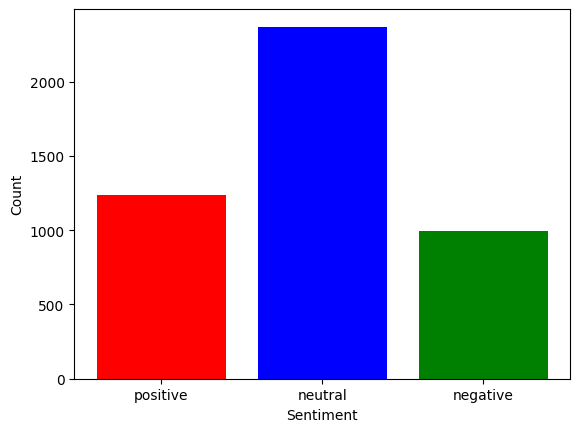

In [16]:
import matplotlib.pyplot as plt

counts = data["sentimen"].value_counts()  
desired_order = ['positive', 'neutral', 'negative']
ordered_counts = counts.reindex(desired_order, fill_value=0)
colors = ['red', 'blue', 'green'] 
plt.bar(ordered_counts.index, ordered_counts.values, color=colors)  

plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("")
plt.show()

In [17]:
data['clean_text'] = data['clean_text'].apply(lambda x: ' '.join(x))


In [18]:
sentiment_mapping = {
    'negative': -1,
    'neutral': 0,
    'positive': 1
}
data['sentimen'] = data['sentimen'].map(sentiment_mapping)
data

,full_text,clean_text,score,sentimen
0,my dream university mixed feeling banget ke un...,my dream university mixed feeling pas selesai ...,1,1
1,Syp utbk nya di gedung arsip unnes cung aku ga...,utbk gedung arsip cung teman,0,0
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,cewek horor lihat temu,-3,-1
3,kantin rektorat unnes malam hari https://t.co/...,kantin rektorat malam,0,0
4,The most delicioso kebab in Unnes the one and ...,the most delicioso kebab in one and only gaza,1,1
...,...,...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,bingung daftar dinas,-2,-1
4602,@unnesmenfess Belum buka nder,buka,0,0
4603,@unnesmenfess Qris bisa nder,qris,0,0
4604,https://t.co/05wpAe4Zpm,,0,0


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
import random

# Assuming data is already loaded
X = data['clean_text']
y = data['sentimen']

random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed, stratify=y)

# TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [20]:
pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())


,abad,abah,abal,abang,abaya,abdi,abiesst,abis,abisin,absen,...,yumcha,yutub,yuuk,zaenuri,zaki,zaman,zhafira,zodiak,zonk,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
from imblearn.over_sampling import SMOTE

# Menggunakan SMOTE
smote = SMOTE(random_state=random_seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

In [22]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Parameter values
C_values = [0.01, 0.1, 1,5, 10]
gamma_values = [1]
coef0_values = [0]
degree_values = [3]

# List to store results
svm_results = []

# Iterate over each kernel and parameter values
for kernel in ['linear', 'rbf', 'sigmoid', 'poly']:
    for C in C_values:
        if kernel == 'linear':
            # For linear kernel, only use parameter C
            model = SVC(kernel=kernel, C=C, random_state=random_seed)
            model.fit(X_train_smote, y_train_smote)
            
            # Predict with test data
            y_pred = model.predict(X_test_tfidf)
            
            # Evaluate performance
            accuracy = accuracy_score(y_test, y_pred)
            
            # Save the result to the list
            svm_results.append({
                "Kernel": kernel,
                "C": C,
                "Gamma": None,
                "Coef0": None,
                "Degree": None,
                "Accuracy": accuracy
            })
            
        elif kernel == 'rbf':
            # For RBF kernel, use C and gamma
            for gamma in gamma_values:
                model = SVC(kernel=kernel, C=C, gamma=gamma, random_state=random_seed)
                model.fit(X_train_smote, y_train_smote)
                
                # Predict with test data
                y_pred = model.predict(X_test_tfidf)
                
                # Evaluate performance
                accuracy = accuracy_score(y_test, y_pred)
                
                # Save the result to the list
                svm_results.append({
                    "Kernel": kernel,
                    "C": C,
                    "Gamma": gamma,
                    "Coef0": None,
                    "Degree": None,
                    "Accuracy": accuracy
                })
                
        elif kernel == 'sigmoid':
            # For sigmoid kernel, use C, gamma, and coef0
            for gamma in gamma_values:
                for coef0 in coef0_values:
                    model = SVC(kernel=kernel, C=C, gamma=gamma, coef0=coef0, random_state=random_seed)
                    model.fit(X_train_smote, y_train_smote)
                    
                    # Predict with test data
                    y_pred = model.predict(X_test_tfidf)
                    
                    # Evaluate performance
                    accuracy = accuracy_score(y_test, y_pred)
                    
                    # Save the result to the list
                    svm_results.append({
                        "Kernel": kernel,
                        "C": C,
                        "Gamma": gamma,
                        "Coef0": coef0,
                        "Degree": None,
                        "Accuracy": accuracy
                    })
                    
        elif kernel == 'poly':
            # For polynomial kernel, use C, gamma, coef0, and degree
            for gamma in gamma_values:
                for coef0 in coef0_values:
                    for degree in degree_values:
                        model = SVC(kernel=kernel, C=C, gamma=gamma, coef0=coef0, degree=degree, random_state=random_seed)
                        model.fit(X_train_smote, y_train_smote)
                        
                        # Predict with test data
                        y_pred = model.predict(X_test_tfidf)
                        
                        # Evaluate performance
                        accuracy = accuracy_score(y_test, y_pred)
                        
                        # Save the result to the list
                        svm_results.append({
                            "Kernel": kernel,
                            "C": C,
                            "Gamma": gamma,
                            "Coef0": coef0,
                            "Degree": degree,
                            "Accuracy": accuracy
                        })

# Convert the list of results to a DataFrame for better visualization
svm_results_df = pd.DataFrame(svm_results)

# Display the table
print(svm_results_df)


     Kernel      C  Gamma  Coef0  Degree  Accuracy
0    linear   0.01    NaN    NaN     NaN  0.662808
1    linear   0.10    NaN    NaN     NaN  0.680897
2    linear   1.00    NaN    NaN     NaN  0.799566
3    linear   5.00    NaN    NaN     NaN  0.803907
4    linear  10.00    NaN    NaN     NaN  0.802460
5       rbf   0.01    1.0    NaN     NaN  0.672938
6       rbf   0.10    1.0    NaN     NaN  0.694645
7       rbf   1.00    1.0    NaN     NaN  0.794501
8       rbf   5.00    1.0    NaN     NaN  0.809696
9       rbf  10.00    1.0    NaN     NaN  0.809696
10  sigmoid   0.01    1.0    0.0     NaN  0.651954
11  sigmoid   0.10    1.0    0.0     NaN  0.680174
12  sigmoid   1.00    1.0    0.0     NaN  0.797395
13  sigmoid   5.00    1.0    0.0     NaN  0.783647
14  sigmoid  10.00    1.0    0.0     NaN  0.769175
15     poly   0.01    1.0    0.0     3.0  0.567294
16     poly   0.10    1.0    0.0     3.0  0.556440
17     poly   1.00    1.0    0.0     3.0  0.575253
18     poly   5.00    1.0    0.

In [26]:
# Fitness function
def fitness_function(params, X_train, y_train, X_test, y_test, kernel):
    # Adjust parameters based on the kernel
    if kernel == 'linear':
        C = params[0]
        model = SVC(C=C, kernel=kernel, random_state=random_seed)

    elif kernel == 'rbf':
        C = params[0]
        gamma = params[1]
        model = SVC(C=C, gamma=gamma, kernel=kernel, random_state=random_seed)

    elif kernel == 'sigmoid':
        C = params[0]
        gamma = params[1]
        coef0 = params[2]
        model = SVC(C=C, gamma=gamma, coef0=coef0, kernel=kernel, random_state=random_seed)

    elif kernel == 'poly':
        C = params[0]
        gamma = params[1]
        coef0 = params[2]
        degree = int(params[3])  # Ensure degree is an integer
        model = SVC(C=C, gamma=gamma, coef0=coef0, degree=degree, kernel=kernel, random_state=random_seed)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Particle class for PSO
class Particle:
    def __init__(self, bounds):
        self.position = np.array([np.random.uniform(bound[0], bound[1]) for bound in bounds])
        self.velocity = np.random.uniform(-1, 1, len(bounds))
        self.best_position = self.position.copy()
        self.best_score = -1

# PSO optimization function with velocity update equation
def pso_optimize(fitness_function, bounds, num_particles, X_train, y_train, X_test, y_test, kernel, num_iterations=10):
    # Parameters for velocity update
    w = 0.5  # Inertia weight
    c1 = 2.0  # Cognitive learning coefficient
    c2 = 2.0  # Social learning coefficient

    particles = [Particle(bounds) for _ in range(num_particles)]
    global_best_position = particles[0].position.copy()
    global_best_score = -1

    print(f"--- Kernel {kernel.capitalize()} ---")
    
    for iteration in range(num_iterations):
        iteration_best_score = -1
        iteration_best_position = None
        
        for particle in particles:
            # Evaluate the fitness of the particle's position
            fitness = fitness_function(particle.position, X_train, y_train, X_test, y_test, kernel)

            # Update the personal best if necessary
            if fitness > particle.best_score:
                particle.best_score = fitness
                particle.best_position = particle.position.copy()

            # Update the global best if necessary
            if fitness > global_best_score:
                global_best_score = fitness
                global_best_position = particle.position.copy()

            # Track the best fitness in this iteration
            if fitness > iteration_best_score:
                iteration_best_score = fitness
                iteration_best_position = particle.position.copy()

            # Random numbers r1 and r2
            r1 = np.random.uniform(0, 1, len(bounds))
            r2 = np.random.uniform(0, 1, len(bounds))

            # Update velocity using PSO equation
            particle.velocity = (
                w * particle.velocity
                + c1 * r1 * (particle.best_position - particle.position)
                + c2 * r2 * (global_best_position - particle.position)
            )

            # Update the particle's position by adding velocity
            particle.position += particle.velocity

            # Ensure the position stays within bounds
            for i in range(len(bounds)):
                if particle.position[i] < bounds[i][0]:
                    particle.position[i] = bounds[i][0]
                if particle.position[i] > bounds[i][1]:
                    particle.position[i] = bounds[i][1]

        # Print the best fitness and parameters from this iteration
        params_str = ', '.join([f"{param:.6f}" for param in iteration_best_position])
        print(f"Iteration {iteration + 1} (params: {params_str}) - Accuracy: {iteration_best_score:.6f}")

    return global_best_position, global_best_score


# Kernels and parameter bounds
kernels = ['linear', 'rbf', 'sigmoid', 'poly']
bounds = {
    'linear': [(0.1, 100)],  # Only C
    'rbf': [(0.1, 100), (0.000001, 1)],  # C and gamma
    'sigmoid': [(0.1, 100), (0.000001, 1), (-1,1)],  # C, gamma, and coef0
    'poly': [(0.1, 100), (0.000001, 1), (-1,1), (2, 5)]  # C, gamma, coef0, and degree
}

# Iterate through each kernel
for kernel in kernels:
    bounds_for_kernel = bounds[kernel]

    # PSO optimization with no iteration, only one evaluation for 10 particles
    best_params, best_score = pso_optimize(fitness_function, bounds_for_kernel, num_particles=10, 
                                           X_train=X_train_smote, y_train=y_train_smote, 
                                           X_test=X_test_tfidf, y_test=y_test, 
                                           kernel=kernel)

    print(f"\nOptimal parameters for {kernel} kernel: {best_params}")

    # Train SVM with optimal parameters
    if kernel == 'poly':
        # Poly kernel requires C, gamma, coef0, and degree
        optimal_svm_clf = SVC(C=best_params[0], gamma=best_params[1], coef0=best_params[2], 
                            degree=int(best_params[3]), kernel=kernel, random_state=random_seed)
    elif kernel == 'sigmoid':
        # Sigmoid kernel requires C, gamma, and coef0
        optimal_svm_clf = SVC(C=best_params[0], gamma=best_params[1], coef0=best_params[2], 
                            kernel=kernel, random_state=random_seed)
    elif kernel == 'rbf':
        # RBF kernel requires C and gamma
        optimal_svm_clf = SVC(C=best_params[0], gamma=best_params[1], 
                            kernel=kernel, random_state=random_seed)
    elif kernel == 'linear':
        # Linear kernel only requires C
        optimal_svm_clf = SVC(C=best_params[0], kernel=kernel, random_state=random_seed)

    # Fit the model and predict
    optimal_svm_clf.fit(X_train_smote, y_train_smote)
    optimal_y_pred = optimal_svm_clf.predict(X_test_tfidf)

    # Calculate accuracy
    accuracy_pso = accuracy_score(y_test, optimal_y_pred)
    print(f"SVM PSO Final Accuracy for {kernel} kernel: {accuracy_pso}")
    
    print("\n" + "="*60 + "\n")

--- Kernel Linear ---
Iteration 1 (params: 32.500505) - Accuracy: 0.805355
Iteration 2 (params: 32.676989) - Accuracy: 0.805355
Iteration 3 (params: 32.389603) - Accuracy: 0.805355
Iteration 4 (params: 32.354560) - Accuracy: 0.805355
Iteration 5 (params: 32.371554) - Accuracy: 0.805355
Iteration 6 (params: 32.680309) - Accuracy: 0.805355
Iteration 7 (params: 32.249845) - Accuracy: 0.805355
Iteration 8 (params: 32.381061) - Accuracy: 0.805355
Iteration 9 (params: 32.747239) - Accuracy: 0.805355
Iteration 10 (params: 32.713263) - Accuracy: 0.805355

Optimal parameters for linear kernel: [32.5005048]
SVM PSO Final Accuracy for linear kernel: 0.8053545586107091


--- Kernel Rbf ---
Iteration 1 (params: 54.073861, 0.079281) - Accuracy: 0.819826
Iteration 2 (params: 58.533809, 0.217933) - Accuracy: 0.816208
Iteration 3 (params: 45.822254, 0.049342) - Accuracy: 0.816932
Iteration 4 (params: 47.300388, 0.075449) - Accuracy: 0.819826
Iteration 5 (params: 54.073892, 0.128359) - Accuracy: 0.81982

In [44]:
#uji coba parameter
from sklearn.metrics import classification_report, accuracy_score

svm_model = SVC(kernel='poly', C=10, gamma=1, coef0=0, degree=3, random_state=random_seed)

svm_model.fit(X_train_smote, y_train_smote)
y_pred = svm_model.predict(X_test_tfidf)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

          -1       0.76      0.12      0.20       299
           0       0.55      0.98      0.71       711
           1       0.82      0.18      0.29       372

    accuracy                           0.58      1382
   macro avg       0.71      0.42      0.40      1382
weighted avg       0.67      0.58      0.49      1382


Accuracy Score:
0.5767004341534009
